## Bernoulli Switchback Experiments

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

def load_data(condition, n_events, design_type="naive-AB"):
    """Load data from a specific condition."""
    if design_type == "switchback":
        # For switchback, condition is the switch_interval
        base_dir = f"output"
        path = Path(f"{base_dir}/switchback/results_{condition}_{n_events}.csv")
        config_path = Path(f"{base_dir}/switchback/config_{condition}_{n_events}.csv")
    else:
        base_dir = f"output/{condition}"
        path = Path(f"{base_dir}/results_{n_events}.csv")
        config_path = Path(f"{base_dir}/config_{n_events}.csv")
    
    data = pd.read_csv(path)
    config = pd.read_csv(config_path)
    return data, config

def calculate_true_ate_stats(pure_a_data, pure_b_data):
    """Calculate true ATE mean and std using pure A and pure B data."""
    # Calculate mean reward for each trajectory
    a_rewards = pure_a_data.groupby('global_trial_id')['reward'].mean()
    b_rewards = pure_b_data.groupby('global_trial_id')['reward'].mean()

    print('control:',a_rewards.values.mean(), 'treatment:', b_rewards.values.mean())
    
    # Calculate ATE for each pair of trajectories
    ate_per_trial = b_rewards.values - a_rewards.values
    
    return ate_per_trial.mean(), ate_per_trial.std(), ate_per_trial

def preprocess_switchback_data(data, switch_interval):
    """Preprocess switchback data by aggregating within intervals."""
    # Handle both 'time_id' and 't' column names
    time_col = 'time_id' if 'time_id' in data.columns else 't'
    
    # Create interval ID based on time_id
    data['interval_id'] = data[time_col] // switch_interval
    
    # Group by trial, interval and calculate means
    interval_data = data.groupby(['global_trial_id', 'interval_id']).agg({
        'reward': 'mean',
        'is_treat': 'first',  # Take first treatment assignment in interval
        'n_available': 'mean',  # Mean available cars in interval
        time_col: 'first'    # Take first time_id in interval
    }).reset_index()
    
    # Ensure consistent column naming
    if time_col == 't':
        interval_data = interval_data.rename(columns={'t': 'time_id'})
    
    return interval_data

def calculate_naive_ate_stats(data, p, is_switchback=False):
    """Calculate naive ATE mean and std using IPW."""
    # For each observation, calculate IPW-adjusted reward
    data['ipw_reward'] = np.where(
        data['is_treat'],
        data['reward'] / p,  # Treatment group: r_t/p
        -data['reward'] / (1-p)  # Control group: -r_t/(1-p)
    )

    # Calculate mean IPW reward for each trajectory
    ate_per_trial = data.groupby('global_trial_id')['ipw_reward'].mean()
    
    return ate_per_trial.mean(), ate_per_trial.std(), ate_per_trial.values

def calculate_dq_estimator_stats(data, k, p, is_switchback=False):
    """Calculate DQ(k) estimator mean and std using IPW."""
    trial_ates = []
    
    # Calculate DQ(k) for each trajectory
    for trial_id, trial_data in data.groupby('global_trial_id'):
        # Sort data by time within trial
        trial_data = trial_data.sort_values('time_id' if is_switchback else 'step_in_trial')
        rewards = trial_data['reward'].values
        is_treat = trial_data['is_treat'].values
        
        # Calculate cumulative sums for fast window calculations
        cum_rewards = np.cumsum(rewards)
        # Prepend a 0 to make the diff calculation easier
        cum_rewards = np.insert(cum_rewards, 0, 0)
        
        # Calculate k-step rewards for each window efficiently
        k_step_rewards = cum_rewards[k:] - cum_rewards[:-k]
        # Get treatment status for the start of each window
        window_treatments = is_treat[:len(k_step_rewards)]
        
        window_estimates = k_step_rewards * (window_treatments / p) - k_step_rewards * ((1-window_treatments) / (1-p))
        trial_ates.append(np.mean(window_estimates))
    
    trial_ates = np.array(trial_ates)
    if len(trial_ates) > 0:
        return trial_ates.mean(), trial_ates.std(), trial_ates
    else:
        return np.nan, np.nan, np.array([])
    
def calculate_dm_dq_estimator_stats(data, k, p, is_switchback=False):
    """Calculate DM version of DQ(k) estimator: difference in mean k-step rewards."""
    trial_ates = []

    for trial_id, trial_data in data.groupby('global_trial_id'):
        # Sort data by time
        trial_data = trial_data.sort_values('time_id' if is_switchback else 'step_in_trial')
        rewards = trial_data['reward'].values
        is_treat = trial_data['is_treat'].values

        # Cumulative reward for fast k-step sum
        cum_rewards = np.cumsum(rewards)
        cum_rewards = np.insert(cum_rewards, 0, 0)

        # Get all k-step reward windows
        k_step_rewards = cum_rewards[k:] - cum_rewards[:-k]
        window_treatments = is_treat[:len(k_step_rewards)]

        # Compute unweighted means by treatment group
        treated_rewards = k_step_rewards[window_treatments == 1]
        control_rewards = k_step_rewards[window_treatments == 0]

        if len(treated_rewards) == 0 or len(control_rewards) == 0:
            continue  # skip if either group is empty

        tau_dm = treated_rewards.mean() - control_rewards.mean()
        trial_ates.append(tau_dm)

    trial_ates = np.array(trial_ates)
    if len(trial_ates) > 0:
        return trial_ates.mean(), trial_ates.std(), trial_ates
    else:
        return np.nan, np.nan, np.array([])

In [2]:
# --- Set Parameters Directly (Notebook Friendly) ---
pure_n_events = 500000  # or any integer of your choice
n_events = 500000  # or any integer of your choice
design = 'switchback'  # or 'switchback'
switch_interval = 3600  # used only if design == 'switchback'

# --- Load Data Based on Design Type ---
if design == "switchback":
    pure_a_data, _ = load_data("pure-A", pure_n_events)
    pure_b_data, _ = load_data("pure-B", pure_n_events)
    naive_ab_data, naive_ab_config = load_data(switch_interval, n_events, design_type="switchback")

    # Only preprocess switchback data
    naive_ab_data = preprocess_switchback_data(naive_ab_data, switch_interval)
else:
    pure_a_data, _ = load_data("pure-A", pure_n_events)
    pure_b_data, _ = load_data("pure-B", pure_n_events)
    naive_ab_data, naive_ab_config = load_data("naive-AB", n_events)

# --- Get Treatment Probability ---
p = naive_ab_config['p'].iloc[0]

# --- Print Time and Driver Statistics ---
print("\nTime and Driver Statistics:")
time_range_seconds = naive_ab_data['time_id'].max() - naive_ab_data['time_id'].min()
print(f"Total time span: {time_range_seconds/3600:.2f} hours")

if design == "switchback":
    n_intervals = len(naive_ab_data['interval_id'].unique())
    print(f"Number of intervals: {n_intervals}")
    print(f"Average events per interval: {len(naive_ab_data)/n_intervals:.2f}")
else:
    print(f"Average time between events: {time_range_seconds/n_events:.2f} seconds")
    print(f"Average available drivers: {naive_ab_data['n_available'].mean():.2f} ± {naive_ab_data['n_available'].std():.2f}")

# --- True ATE Calculation ---
true_ate_mean, true_ate_std, true_ate_per_trial = calculate_true_ate_stats(pure_a_data, pure_b_data)
print(f"\nTrue ATE: {true_ate_mean:.4f} ± {true_ate_std:.4f}")


Time and Driver Statistics:
Total time span: 137470.00 hours
Number of intervals: 145
Average events per interval: 100.00
control: 1.6723507893888458 treatment: 2.95466653019756

True ATE: 1.2823 ± 0.0247


## DM/DQ Estimators

In [3]:
from typing import List, Dict, Tuple
from tqdm import tqdm

def run_tr_dq_estimators(
    switch_intervals: List[int],
    k_values: List[int],
    n_events: int = 500000,
    pure_n_events: int = 500000
) -> Dict[Tuple[int, int], np.ndarray]:
    
    dq_ates_dict = {}

    for interval in tqdm(switch_intervals):
        naive_ab_data, naive_ab_config = load_data(interval, n_events, design_type="switchback")
        naive_ab_data = preprocess_switchback_data(naive_ab_data, interval)
        
        p = naive_ab_config['p'].iloc[0]
        
        for k in tqdm(k_values):
            dq_ate_mean, dq_ate_std, dq_ate_per_trial = calculate_dq_estimator_stats(
                naive_ab_data, k, p, is_switchback=True
            )
            dq_ates_dict[(interval, k-1)] = dq_ate_per_trial
    
    return dq_ates_dict

dq_ates_dict = run_tr_dq_estimators(
    switch_intervals=[600, 1200, 1800],
    k_values=[2,3,4],
    n_events=n_events,
    pure_n_events=pure_n_events
)

100%|██████████| 3/3 [00:34<00:00, 11.45s/it]


In [4]:
from typing import List, Dict, Tuple
from tqdm import tqdm

def run_tr_dm_dq_estimators(
    switch_intervals: List[int],
    k_values: List[int],
    n_events: int = 500000,
    pure_n_events: int = 500000
) -> Dict[Tuple[int, int], np.ndarray]:
    
    dq_ates_dict = {}

    for interval in tqdm(switch_intervals):
        naive_ab_data, naive_ab_config = load_data(interval, n_events, design_type="switchback")
        naive_ab_data = preprocess_switchback_data(naive_ab_data, interval)
        
        p = naive_ab_config['p'].iloc[0]
        
        for k in tqdm(k_values):
            dq_ate_mean, dq_ate_std, dq_ate_per_trial = calculate_dm_dq_estimator_stats(
                naive_ab_data, k, p, is_switchback=True
            )
            dq_ates_dict[(interval, k-1)] = dq_ate_per_trial
    
    return dq_ates_dict

dm_dq_ates_dict = run_tr_dm_dq_estimators(
    switch_intervals=[600, 1200, 1800],
    k_values=[2,3,4],
    n_events=n_events,
    pure_n_events=pure_n_events
)

100%|██████████| 3/3 [00:35<00:00, 11.90s/it]


In [5]:
def run_dm_estimators(
    switch_intervals: List[int],
    n_events: int = 500000,
    pure_n_events: int = 500000
) -> Dict[Tuple[int, int], np.ndarray]:
    
    dm_ates_dict = {}

    for interval in tqdm(switch_intervals):
        naive_ab_data, naive_ab_config = load_data(interval, n_events, design_type="switchback")
        naive_ab_data = preprocess_switchback_data(naive_ab_data, interval)
        
        p = naive_ab_config['p'].iloc[0]
        
        dm_ate_mean, dm_ate_std, dm_ate_per_trial = calculate_dm_dq_estimator_stats(
                naive_ab_data, 1, p, is_switchback=True)
        dm_ates_dict[(interval, 0)] = dm_ate_per_trial
    
    return dm_ates_dict

dm_ates_dict = run_dm_estimators(
    switch_intervals=[600, 1200, 1800, 3600],
    n_events=n_events,
    pure_n_events=pure_n_events
)

100%|██████████| 4/4 [00:46<00:00, 11.75s/it]


## LSTD DQ/OPE Estimators

In [6]:
from typing import List, Dict, Tuple
import numpy as np
from tqdm import tqdm

def run_lstd_ope_estimators_aligned(
    switch_intervals: List[int],
    n_events: int = 500000
) -> Tuple[Dict[Tuple[int, int], np.ndarray], Dict[Tuple[int, int], np.ndarray]]:
    
    lstd_results = {}
    ope_results = {}

    for interval in tqdm(switch_intervals):
        # Load and preprocess data
        naive_ab_data, naive_ab_config = load_data(interval, n_events, design_type="switchback")
        naive_ab_data = preprocess_switchback_data(naive_ab_data, interval)

        # --- LSTD-DQ Estimator ---
        dq_estimates = []
        for trial_id, df_trial in naive_ab_data.groupby('global_trial_id'):
            ss = df_trial[['n_available']].values[:-1]
            snews = df_trial[['n_available']].values[1:]
            rs = df_trial['reward'].values[:-1]
            Z = df_trial['is_treat'].values[:-1]
            
            if len(ss) == 0:
                continue

            A = ss.T @ (ss - snews)
            b = ss.T @ (rs - np.mean(rs))
            theta_dq = np.linalg.solve(A + 1e-3 * np.eye(A.shape[0]), b)

            xbar1 = ss[Z == 1].mean(axis=0) if np.sum(Z == 1) > 0 else np.zeros_like(theta_dq)
            xbar0 = ss[Z == 0].mean(axis=0) if np.sum(Z == 0) > 0 else np.zeros_like(theta_dq)

            dq_estimates.append(theta_dq @ (xbar1 - xbar0))
        lstd_results[(interval, 0)] = np.array(dq_estimates)

        # --- OPE Estimator ---
        ope_estimates = []
        for trial_id, df_trial in naive_ab_data.groupby('global_trial_id'):
            ss = df_trial[['n_available']].values[:-1]
            snews = df_trial[['n_available']].values[1:]
            rs = df_trial['reward'].values[:-1]
            Z = df_trial['is_treat'].values[:-1]

            if len(ss) == 0:
                continue

            ss1 = ss[Z == 1]
            snews1 = snews[Z == 1]
            rs1 = rs[Z == 1]

            ss0 = ss[Z == 0]
            snews0 = snews[Z == 0]
            rs0 = rs[Z == 0]

            if len(ss1) == 0 or len(ss0) == 0:
                continue

            A1 = ss1.T @ (ss1 - snews1)
            b1 = ss1.T @ rs1
            eta1 = np.linalg.solve(A1 + 1e-3 * np.eye(A1.shape[0]), b1)[0]

            A0 = ss0.T @ (ss0 - snews0)
            b0 = ss0.T @ rs0
            eta0 = np.linalg.solve(A0 + 1e-3 * np.eye(A0.shape[0]), b0)[0]

            ope_estimates.append(eta1 - eta0)
        ope_results[(interval, 0)] = np.array(ope_estimates)

    return lstd_results, ope_results

# Run for the given switch intervals
switch_intervals = [3600]
lstd_results_aligned, ope_results_aligned = run_lstd_ope_estimators_aligned(switch_intervals=switch_intervals)


100%|██████████| 1/1 [00:11<00:00, 11.30s/it]


## BC Estimators

In [7]:
def compute_bias_corrected_switchback_ate_by_trial(df, switch_interval=3600, burn_in_seconds=300):
    df = df.copy()
    estimates = []

    for trial_id, df_trial in df.groupby("global_trial_id"):
        df_trial = df_trial.copy()

        # Convert time_id to datetime
        df_trial['ts'] = pd.to_datetime(df_trial['event_time_id'], unit='s')

        # Define blocks and focal region
        block_duration = pd.Timedelta(seconds=switch_interval)
        df_trial['block_start'] = df_trial['ts'].dt.floor(f'{switch_interval}s')
        df_trial['block'] = df_trial['block_start'].rank(method='dense').astype(int) - 1
        df_trial['block_time'] = df_trial['ts'] - df_trial['block_start']
        df_trial['in_focal'] = df_trial['block_time'] > pd.Timedelta(seconds=burn_in_seconds)

        # Focal periods only
        focal = df_trial[df_trial['in_focal']]
        mu1 = focal[focal['is_treat'] == True]['reward'].mean()
        mu0 = focal[focal['is_treat'] == False]['reward'].mean()
        tau_dm = mu1 - mu0

        # Block-level treatment assignment
        block_treat = df_trial.groupby('block').first()['is_treat'].astype(int)
        block_treat_prev = block_treat.shift()

        k11_blocks = block_treat[(block_treat == 1) & (block_treat_prev == 1)].index
        k00_blocks = block_treat[(block_treat == 0) & (block_treat_prev == 0)].index

        def burnin_avg(block_ids):
            if len(block_ids) == 0:
                return 0.0
            burnin_rows = df_trial[(df_trial['block'].isin(block_ids)) & 
                                   (df_trial['block_time'] <= pd.Timedelta(seconds=burn_in_seconds))]
            block_sizes = df_trial[df_trial['block'].isin(block_ids)].groupby('block').size()
            burnin_sums = burnin_rows.groupby('block')['reward'].sum()
            correction_terms = burnin_sums / block_sizes
            return correction_terms.mean() if not correction_terms.empty else 0.0

        correction_11 = burnin_avg(k11_blocks)
        correction_00 = burnin_avg(k00_blocks)

        block_counts = df_trial.groupby('block').size()
        burnin_counts = df_trial[df_trial['block_time'] <= pd.Timedelta(seconds=burn_in_seconds)].groupby('block').size()
        avg_block_size = block_counts.mean()
        avg_burnin_size = burnin_counts.reindex(block_counts.index, fill_value=0).mean()

        tau_bc = ((avg_block_size - avg_burnin_size) / avg_block_size) * tau_dm if avg_block_size > 0 else tau_dm
        if len(k11_blocks) > 0 and np.isfinite(correction_11):
            tau_bc += correction_11
        if len(k00_blocks) > 0 and np.isfinite(correction_00):
            tau_bc -= correction_00

        estimates.append(tau_bc)

    # Aggregate results
    estimates_series = pd.Series(estimates)
    tau_mean = estimates_series.mean()
    tau_std = estimates_series.std()

    return tau_mean, tau_std, estimates_series

In [8]:
from typing import List, Dict, Tuple
import numpy as np
import pandas as pd

def run_bc_estimators(
    switch_intervals: List[int],
    burnin_minutes_list: List[int],
    n_events: int = 500000
) -> Dict[Tuple[int, int], np.ndarray]:
    bc_results = {}

    for interval in switch_intervals:
        BC_sw_data, _ = load_data(interval, n_events, design_type="switchback")
        for burnin_min in burnin_minutes_list:
            burnin_sec = burnin_min * 60
            tau_mean, tau_std, estimates_series = compute_bias_corrected_switchback_ate_by_trial(
                BC_sw_data, switch_interval=interval, burn_in_seconds=burnin_sec
            )
            bc_results[(interval, burnin_min)] = np.array(estimates_series)

    return bc_results

In [9]:
# Now run the BC estimators for the specified configurations
bc_results_dict = run_bc_estimators(
    switch_intervals=[3600],
    burnin_minutes_list=[10, 20]
)

## Plots

Saved box plot to plots/ride_box_plots.pdf


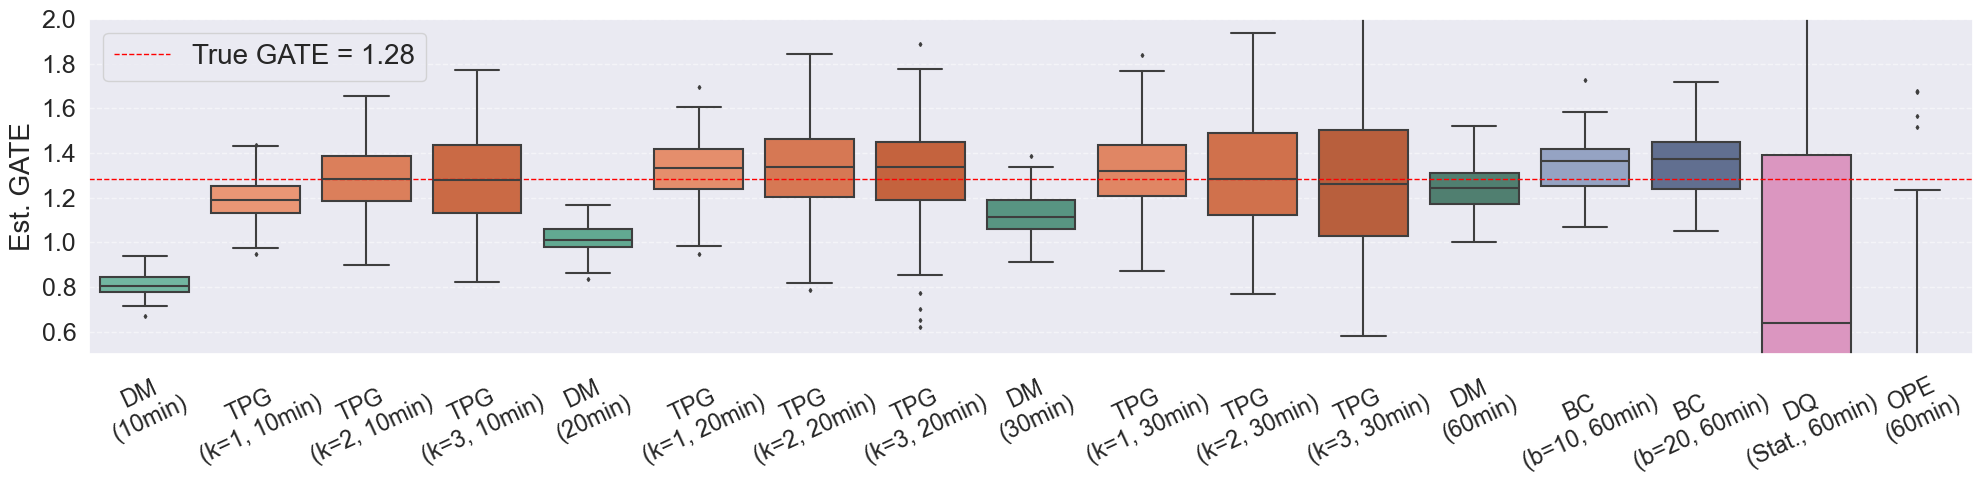

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import colorsys
from collections import defaultdict
from matplotlib.colors import to_rgba

sns.set()

# --- Define subtle tinting function ---
def tint_color(color, intensity=1.0):
    r, g, b = color
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l = l * (0.4 + 0.6 * intensity)
    s = s * (0.4 + 0.6 * intensity)
    return colorsys.hls_to_rgb(h, l, s)

# --- Base color assignments per estimator type ---
base_colors = {
    'DM': sns.color_palette("Set2")[0],
    'TPG': sns.color_palette("Set2")[1],
    'BC': sns.color_palette("Set2")[2],
    'DQ': sns.color_palette("Set2")[3],
    'OPE': sns.color_palette("Set2")[4],
}

# --- Data collection setup ---
records = []
estimator_groups = defaultdict(list)

def add_estimator(estimator_type, params_str, values):
    label = f"{estimator_type}\n{params_str}"
    estimator_groups[estimator_type].append((label, values))

# --- Register all estimators ---
for (interval, _), estimates in dm_ates_dict.items():
    add_estimator("DM", f"({interval//60}min)", estimates)

for (interval, k), estimates in dm_dq_ates_dict.items():
    add_estimator("TPG", f"(k={k}, {interval//60}min)", estimates)

for (interval, burnin), estimates in bc_results_dict.items():
    add_estimator("BC", f"(b={burnin}, {interval//60}min)", estimates)

for (interval, _), estimates in lstd_results_aligned.items():
    add_estimator("DQ", f"(Stat., {interval//60}min)", estimates)

for (interval, _), estimates in ope_results_aligned.items():
    add_estimator("OPE", f"({interval//60}min)", estimates)

# --- Assign progressively darker shades per estimator type ---
label_color_map = {}

for est_type, items in estimator_groups.items():
    n = len(items)
    for i, (label, values) in enumerate(sorted(items)):
        intensity = 1.0 - 0.5 * i / max(n - 1, 1)
        color = tint_color(base_colors[est_type], intensity=intensity)
        label_color_map[label] = color
        records.extend([{"Estimator": label, "Est. GATE": v} for v in values])

# --- Create DataFrame ---
plot_df = pd.DataFrame.from_records(records)

# --- Define new order grouped by interval ---
custom_labels = [
    # 10-minute interval group
    'DM\n(10min)',
    'TPG\n(k=1, 10min)', 'TPG\n(k=2, 10min)', 'TPG\n(k=3, 10min)',

    # 20-minute interval group
    'DM\n(20min)',
    'TPG\n(k=1, 20min)', 'TPG\n(k=2, 20min)', 'TPG\n(k=3, 20min)',

    # 30-minute interval group
    'DM\n(30min)',
    'TPG\n(k=1, 30min)', 'TPG\n(k=2, 30min)', 'TPG\n(k=3, 30min)',

    # 60-minute group
    'DM\n(60min)',
    'BC\n(b=10, 60min)', 'BC\n(b=20, 60min)',
    'DQ\n(Stat., 60min)', 'OPE\n(60min)',
]

# --- Set categorical order ---
plot_df['Estimator'] = pd.Categorical(
    plot_df['Estimator'],
    categories=custom_labels,
    ordered=True
)

# --- Plot ---
plt.figure(figsize=(20, 5))
sns.boxplot(
    data=plot_df,
    x="Estimator",
    y="Est. GATE",
    palette=label_color_map,
    fliersize=2
)

ax = plt.gca()
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(custom_labels, rotation=25, fontsize=17)

plt.axhline(true_ate_mean, color='red', linestyle='--', linewidth=1, label=f"True GATE = {true_ate_mean:.2f}")
plt.yticks(fontsize=18)
plt.ylabel("Est. GATE", fontsize=20)
plt.xlabel("", fontsize=16)
plt.ylim(0.5, 2)
plt.legend(fontsize=20)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

filename = "plots/ride_box_plots.pdf"
plt.savefig(filename)
print(f"Saved box plot to {filename}")
plt.show()
